<a href="https://colab.research.google.com/github/AIM-Harvard/aimi_alpha/blob/main/aimi/totalsegmentator/notebooks/totalseg_mwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ModelHub - TotalSegmentator**

Minimal Working Example for cloud-based analysis of data using the TotalSegmentator model (with a focus on cardiac substructures).

---

## **Init & Imports**

In order to access the IDC resources, the user must complete at first the Google authentication process.

To continue with the notebook, when prompted by the next code cell follow the generated link. After granting Google Cloud SDK access to the selected Google account, you will get a one-use login code. Copy the code, paste it in the blank space under the cell, and press enter to complete the authentication procedure.

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# useful information

curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /content
Hostname          : 6b384c8f131d
Username          : root


To proceed with the cells below you will also need to:
* Initialize `myProjectID` in the cell below with a project ID that you can bill
* Generate a table name `cohortBQTable` through IDC (be aware you will also need to paste this manually in the BigQuery download cell)

In [ ]:
## INSERT YOUR OWN PROJECT-ID AND BIGQUERY TABLE NAME HERE!
myProjectID = "idc-sandbox-000"

Before continuing with the notebook, we need to set-up the Google Colab environment by installing the Python and system dependencies the pre-processing and processing pipeline rely on.

### **Python Dependencies**

Install and import all the Python dependencies.

The main python packages we need to install are:

* [PyPlastimatch](https://github.com/AIM-Harvard/pyplastimatch), a Python wrapper for Plastimatch that lets the user run Plastimatch functions in an easy "pythonic" way;
* [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets), a Python package for interactive visualization of images, point sets, and meshes in notebook environments;
* [TotalSegmentator](https://github.com/wasserth/TotalSegmentator), a DL-based tool for robust segmentation of 104 important anatomical structures in CT images.



In [ ]:
%%capture
!pip install pyplastimatch
!pip install ipywidgets
!pip install TotalSegmentator

In [ ]:
import os
import sys
import time
import shutil
import random

import json
import pprint
import numpy as np
import pandas as pd

import pydicom
import nibabel as nib
import SimpleITK as sitk

print("Python version               : ", sys.version.split('\n')[0])
print("Numpy version                : ", np.__version__)

# ----------------------------------------

#everything that has to do with plotting goes here below
import matplotlib
matplotlib.use("agg")

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

%matplotlib inline
%config InlineBackend.figure_format = "png"

import ipywidgets as ipyw

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a \"color overlay\" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:, -1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:, -1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:, -1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:, -1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)
## ----------------------------------------

import seaborn as sns

Python version               :  3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy version                :  1.21.6


### **System Dependencies**

Install all the system dependencies. 

The only package we will need for this tutorial is [Plastimatch](https://plastimatch.org/index.html). Plastimatch is considered to be the swiss army knife of medical images processing: we will use it to convert DICOM (CT, RTSTRUCT) series to NRRD files - but it can be used for a multitude of other tasks, such as registration, resampling, cropping, and computing statistics to name a few. Plastimatch is also available as a 3DSlicer plug-in and can be used directly from the Slicer GUI.

For the sake of clarity and simplicity, we will call Plastimatch from a very simple [Python wrapper](https://github.com/AIM-Harvard/pyplastimatch) written for the occasion (unfortunately, Plastimatch does not provide an official one) - more on this later.

In [ ]:
%%capture
!sudo apt update
!sudo apt install plastimatch

In [ ]:
!echo $(plastimatch --version)

plastimatch version 1.7.0


---

## **Cohort Download**

For this use case, we are going to pull data from the Imaging Data Commons (IDC).

To download the data on the Colab instance, users can exploit the BigQuery table/manifest files associated with the IDC dataset(s), select the cohort(s) of interest, and then download the files exploiting `gsutil`. BigQuery export of the cohort manifest is the recommended approach (see the [Cohort Download Notebook](https://colab.research.google.com/github/ImagingDataCommons/IDC-Examples/blob/master/notebooks/Cohort_download.ipynb) for a more detailed explanation).

**Note**: simpler cohort selection operations can also be done through the graphic user interface at the [IDC Portal](https://portal.imaging.datacommons.cancer.gov/). If you want to learn more, please refer to the [IDC User Guide](https://learn.canceridc.dev/).

### **Downloading the Data from GCS**

Query the IDC BigQuery table to parse only DICOM Series that follow the specified rules (e.g., maximum SliceThickness, minimum and maximum Slices per series, etc.)

In [ ]:
from google.cloud import bigquery as bq

In [ ]:
%%bigquery --project=$myProjectID cohort_df

WITH
  nlst_instances_per_series AS (
  SELECT
    SeriesInstanceUID,
    COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
    COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
    COUNT(DISTINCT(ARRAY_TO_STRING(PixelSpacing,"/"))) AS pixel_spacing_count,
    COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
    MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
    MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
    STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    collection_id = "nlst"
    AND Modality = "CT"
  GROUP BY
    SeriesInstanceUID)
SELECT
  ANY_VALUE(dicom_all.PatientID) AS PatientID,
  ANY_VALUE(dicom_all.ClinicalTrialTimePointID) AS ClinicalTrialTimePointID,
  ANY_VALUE(StudyInstanceUID) AS StudyInstanceUID,
  dicom_all.SeriesInstanceUID,
  ANY_VALUE(dicom_all.gcs_url) AS gcs_url,
  any_value(array_to_string(ImageType,"/")) as ImageType,
  ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
  ANY_VALUE(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID,"?seriesInstanceUID=",dicom_all.SeriesInstanceUID)) AS idc_url
FROM
  `bigquery-public-data.idc_current.dicom_all` AS dicom_all
JOIN
  nlst_instances_per_series
ON
  dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
WHERE
  nlst_instances_per_series.min_SliceThickness >= 1.5
  AND nlst_instances_per_series.max_SliceThickness <= 3.5
  AND nlst_instances_per_series.num_instances > 100
  AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
  AND nlst_instances_per_series.pixel_spacing_count = 1
  AND nlst_instances_per_series.orientation_count = 1
  AND has_localizer = "false"
GROUP BY
  SeriesInstanceUID
ORDER BY
  num_instances DESC

After populating the Pandas DataFrame with the result of the bigquery query, we can inspect it to make sure it looks ok.

As you will see, each DICOM slice has its own entry (that's why one has to remove `LIMIT 1000` from the query to get the complete result) and a series of useful information:
* on the dataset it belongs to - especially useful in the case multiple datasets are exported as part of an IDC cohort - such as the `collection_id` and the `source_DOI`;
* on the patient, study, and series it belongs to, such as the `PatientID`, `StudyInstanceUID` and `SeriesInstanceUID`;
* on the GCS bucket location and organisation, such as `gcs_url`, `crdc_instance_uuid`, and `crdc_series_uuid`.



In [ ]:
display(cohort_df.info())
display(cohort_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105433 entries, 0 to 105432
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   PatientID                 105433 non-null  object
 1   ClinicalTrialTimePointID  105433 non-null  object
 2   StudyInstanceUID          105433 non-null  object
 3   SeriesInstanceUID         105433 non-null  object
 4   gcs_url                   105433 non-null  object
 5   ImageType                 105433 non-null  object
 6   num_instances             105433 non-null  int64 
 7   idc_url                   105433 non-null  object
dtypes: int64(1), object(7)
memory usage: 6.4+ MB


None

,PatientID,ClinicalTrialTimePointID,StudyInstanceUID,SeriesInstanceUID,gcs_url,ImageType,num_instances,idc_url
0,205587,T1,1.3.6.1.4.1.14519.5.2.1.7009.9004.264250238402...,1.3.6.1.4.1.14519.5.2.1.7009.9004.164051293739...,gs://public-datasets-idc/5ff1f97c-d6d0-4958-84...,ORIGINAL/SECONDARY/AXIAL,420,https://viewer.imaging.datacommons.cancer.gov/...
1,208080,T0,1.3.6.1.4.1.14519.5.2.1.7009.9004.328840429544...,1.3.6.1.4.1.14519.5.2.1.7009.9004.214587271061...,gs://public-datasets-idc/971482ab-fb4a-4564-b0...,ORIGINAL/PRIMARY/AXIAL,407,https://viewer.imaging.datacommons.cancer.gov/...
2,211793,T2,1.3.6.1.4.1.14519.5.2.1.7009.9004.190678544004...,1.3.6.1.4.1.14519.5.2.1.7009.9004.132169525013...,gs://public-datasets-idc/3832c54b-f85a-4a63-b5...,ORIGINAL/PRIMARY/AXIAL/CT_SOM5 SPI,404,https://viewer.imaging.datacommons.cancer.gov/...
3,216656,T1,1.3.6.1.4.1.14519.5.2.1.7009.9004.104804016892...,1.3.6.1.4.1.14519.5.2.1.7009.9004.803218179974...,gs://public-datasets-idc/9d37df25-931b-46dd-9b...,ORIGINAL/PRIMARY/AXIAL/CT_SOM5 SPI,403,https://viewer.imaging.datacommons.cancer.gov/...
4,203392,T0,1.3.6.1.4.1.14519.5.2.1.7009.9004.210450987398...,1.3.6.1.4.1.14519.5.2.1.7009.9004.221805121025...,gs://public-datasets-idc/38b6474f-75ef-4a71-af...,ORIGINAL/PRIMARY/AXIAL,399,https://viewer.imaging.datacommons.cancer.gov/...


Randomly pick a patient from the selected cohort, and a random series from the patient.

In [ ]:
pat_id = random.choice(cohort_df["PatientID"].values)
pat_df = cohort_df[cohort_df["PatientID"] == pat_id].reset_index(drop = True)

display(pat_df.info())
display(pat_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   PatientID                 4 non-null      object
 1   ClinicalTrialTimePointID  4 non-null      object
 2   StudyInstanceUID          4 non-null      object
 3   SeriesInstanceUID         4 non-null      object
 4   gcs_url                   4 non-null      object
 5   ImageType                 4 non-null      object
 6   num_instances             4 non-null      int64 
 7   idc_url                   4 non-null      object
dtypes: int64(1), object(7)
memory usage: 384.0+ bytes


None

,PatientID,ClinicalTrialTimePointID,StudyInstanceUID,SeriesInstanceUID,gcs_url,ImageType,num_instances,idc_url
0,114784,T1,1.2.840.113654.2.55.15764231351217013484936855...,1.2.840.113654.2.55.19048850122810719995793083...,gs://public-datasets-idc/9a617a35-8312-4b1e-97...,ORIGINAL/PRIMARY/AXIAL/CT_SOM5 SPI,151,https://viewer.imaging.datacommons.cancer.gov/...
1,114784,T2,1.2.840.113654.2.55.52413444317985108341844396...,1.2.840.113654.2.55.33536449067199903922845750...,gs://public-datasets-idc/0a377d0b-6acd-4b09-93...,ORIGINAL/PRIMARY/AXIAL/CT_SOM5 SPI,141,https://viewer.imaging.datacommons.cancer.gov/...
2,114784,T2,1.2.840.113654.2.55.52413444317985108341844396...,1.2.840.113654.2.55.31734695303564519359453324...,gs://public-datasets-idc/0dd16d9c-a284-4b00-a0...,ORIGINAL/PRIMARY/AXIAL/CT_SOM5 SPI,141,https://viewer.imaging.datacommons.cancer.gov/...
3,114784,T0,1.2.840.113654.2.55.23382493319673775928693987...,1.2.840.113654.2.55.33046879171236627892745134...,gs://public-datasets-idc/63842e13-b4c3-4018-91...,ORIGINAL/PRIMARY/AXIAL/CT_SOM5 SPI,138,https://viewer.imaging.datacommons.cancer.gov/...


In [ ]:
sample_df = pat_df.sample()

display(sample_df.info())
display(sample_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   PatientID                 1 non-null      object
 1   ClinicalTrialTimePointID  1 non-null      object
 2   StudyInstanceUID          1 non-null      object
 3   SeriesInstanceUID         1 non-null      object
 4   gcs_url                   1 non-null      object
 5   ImageType                 1 non-null      object
 6   num_instances             1 non-null      int64 
 7   idc_url                   1 non-null      object
dtypes: int64(1), object(7)
memory usage: 72.0+ bytes


None

,PatientID,ClinicalTrialTimePointID,StudyInstanceUID,SeriesInstanceUID,gcs_url,ImageType,num_instances,idc_url
1,114784,T2,1.2.840.113654.2.55.52413444317985108341844396...,1.2.840.113654.2.55.33536449067199903922845750...,gs://public-datasets-idc/0a377d0b-6acd-4b09-93...,ORIGINAL/PRIMARY/AXIAL/CT_SOM5 SPI,141,https://viewer.imaging.datacommons.cancer.gov/...


The selected series can be inspected at the following link:

In [ ]:
sample_df["idc_url"].values

array(['https://viewer.imaging.datacommons.cancer.gov/viewer/1.2.840.113654.2.55.52413444317985108341844396392932491845?seriesInstanceUID=1.2.840.113654.2.55.335364490671999039228457505698033589149'],
      dtype=object)

In [ ]:
series_id_list = list()
series_id_list.append(sample_df["SeriesInstanceUID"].values[0])

All the DICOM slices in the DICOM Series:

In [ ]:
# create the directory tree
!mkdir -p tutorial 
!mkdir -p tutorial/data tutorial/output
!mkdir -p tutorial/data/tmp tutorial/data/dicom tutorial/data/processed tutorial/data/totalSeg

In [ ]:
query_view = f"""
  SELECT 
    PatientID,
    gcs_url
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    SeriesInstanceUID IN UNNEST(@series_id_list);
  """

client = bq.Client(project = myProjectID)

job_config = bq.QueryJobConfig(query_parameters = [
    bq.ArrayQueryParameter("series_id_list", "STRING", series_id_list)
    ])

result = client.query(query_view, job_config = job_config)
gcs_df = result.to_dataframe()

gs_file_path = "tutorial/data/gcs_paths.txt"
gcs_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

In [ ]:
%%capture
# https://cloud.google.com/storage/docs/gsutil/commands/cp
!mkdir -p tutorial/data/tmp
!cat $gs_file_path | gsutil -u $myProjectID -m cp -Ir tutorial/data/tmp

As you will notice, for instance, by browsing the `tutorial/data/tmp` folder, the DICOM files will not be organised by default following patients, series, or studies.

To organise the data in a more common (and human-understandable) fashion, we will make use of [DICOMSort](https://github.com/pieper/dicomsort). DICOMSort is an open source tool for custom sorting and renaming of dicom files based on their specific DICOM tags. In our case, we will exploit DICOMSort to organise the DICOM data by `PatientID`, `Modality`, and `SOPInstanceUID` - so that the final directory will look like the following:

```
tutorial/data/dicom/$PatientID
 └─── $Modality
       ├─── $SOPInstanceUID_slice0.dcm
       ├─── $SOPInstanceUID_slice1.dcm
       ├───  ...
```

Furthermore, to prepare the data for processing (e.g., data conversion from DICOM) we will make use of [PyPlastimatch](https://github.com/denbonte/pyplastimatch/), a very basic python wrapper for Plastimatch, written for the purpose of this tutorial. The wrapper also contains a very basic yet interactive visualisation function we will be using in the last part of the notebook to check the segmentation results.

In [ ]:
# DICOMSORT - for re-organising DICOM files in folders
!git clone https://github.com/pieper/dicomsort.git tutorial/dicomsort

Cloning into 'tutorial/dicomsort'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 130 (delta 0), reused 1 (delta 0), pack-reused 126
Receiving objects: 100% (130/130), 44.12 KiB | 7.35 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
# run the DICOMSort command
!python tutorial/dicomsort/dicomsort.py -u tutorial/data/tmp tutorial/data/dicom/%PatientID/%Modality/%SOPInstanceUID.dcm

# get rid of the temporary folder, storing the unsorted DICOM data 
!rm -r tutorial/data/tmp

100% 141/141 [00:00<00:00, 455.84it/s]
Files sorted


---

## **Data Pre-processing**


Using the simple Plastimatch wrapper, let's convert the DICOM CT series in both NRRD and NIfTI format. Furthermore, we are going to convert the DICOM RTSTRUCT Series into a NRRD volume as well.


In [ ]:
import pyplastimatch as pypla

from pyplastimatch.utils import viz as viz_utils

### **DICOM to NRRD/NIfTI Conversion**

Let's use the functions from the simple wrapper to convert the data into the formats mentioned above exploiting Plastimatch.

In [ ]:
pat_id = sample_df["PatientID"].values[0]

# directories storing NRRD and NIfTI files
base_preproc_path = "tutorial/data/processed"

pat_dir_path_nii = os.path.join(base_preproc_path, "nii", pat_id)
  
# patient subfolder where all the preprocessed NIfTIs will be stored
if not os.path.exists(pat_dir_path_nii): os.makedirs(pat_dir_path_nii)

# path to the directory where the DICOM CT file is stored
path_to_ct_dir = os.path.join("tutorial/data/dicom", pat_id, "CT")

# path to the files where the NIfTI CTs will be stored
ct_nii_path = os.path.join(pat_dir_path_nii, pat_id + "_CT.nii.gz")

verbose = True

# logfile for the plastimatch conversion
log_file_path_nii = os.path.join(pat_dir_path_nii, pat_id + '_pypla.log')
  
# DICOM CT to NIfTI conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nii_path):
  convert_args_nii = {"input" : path_to_ct_dir, 
                      "output-img" : ct_nii_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nii): os.remove(log_file_path_nii)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/114784/CT
  --output-img tutorial/data/processed/nii/114784/114784_CT.nii.gz
... Done.


The folder `/content/tutorial/data/processed` now stores the NIfTI file ready to be ingested by the image processing pipeline.

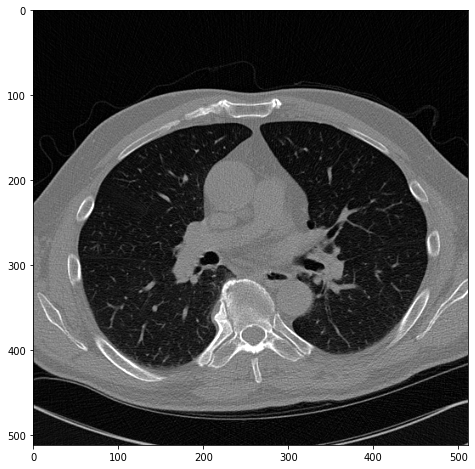

In [ ]:
ct_nii = sitk.GetArrayFromImage(sitk.ReadImage(ct_nii_path))

axial_idx = int(ct_nii.shape[0]/2)

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

_ = ax.imshow(ct_nii[axial_idx, :, :], 
              cmap = "gray",
              vmin = -1024, vmax = 1024)

## **Data Processing**

In [ ]:
totalseg_base_output_dir = "tutorial/data/totalSeg"
totalseg_pat_output_dir = os.path.join(totalseg_base_output_dir, pat_id)

if not os.path.exists(totalseg_pat_output_dir):
  os.makedirs(totalseg_pat_output_dir)

start_time = time.time()

!TotalSegmentator -i $ct_nii_path -o $totalseg_pat_output_dir

end_time = time.time()

print ('Time elapsed: ', end_time - start_time)

/root/.totalsegmentator/nnunet/results/nnUNet/3d_fullres
/root/.totalsegmentator/nnunet/results/nnUNet/3d_fullres
/root/.totalsegmentator/nnunet/results/nnUNet/3d_fullres
/root/.totalsegmentator/nnunet/results/nnUNet/3d_fullres
/root/.totalsegmentator/nnunet/results/nnUNet/3d_fullres
Resampling...
Predicting part 0 of 5 ...
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
  Predicted in 59.83s
Resampling...
Saving segmentations...
100% 104/104 [00:25<00:00,  4.09it/s]
  Saved in 26.12s
Time elapsed:  477.9571568965912


---

## **Data Visualisation**

Simple interactive axial slice (and segmentation) visualisation.

In [ ]:
seg_vol_list = ["aorta.nii.gz",
                "heart_atrium_left.nii.gz",
                "heart_atrium_right.nii.gz",
                ]

#seg_vol_list = [f for f in os.listdir(totalseg_pat_output_dir) if ".nii.gz" in f]

segmask_dict = dict()
segmask_cmap_dict = dict()

cmap_list = [my_spring, my_reds, my_blues, my_greens]

for seg_vol_name in seg_vol_list:

  structure_name = seg_vol_name.split(".nii.gz")[0]

  seg_nii_path = os.path.join(totalseg_pat_output_dir, seg_vol_name)

  segmask_dict[structure_name] = sitk.GetArrayFromImage(sitk.ReadImage(seg_nii_path))
  segmask_cmap_dict[structure_name] = cmap_list[np.random.randint(len(cmap_list))]

In [ ]:
_ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_nii,
                                   segmask_dict = segmask_dict,
                                   segmask_cmap_dict = segmask_cmap_dict,
                                   dpi = 100, figsize = (8, 8),
                                   min_hu = -1024, max_hu = 1024)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## **Data Download**

In [ ]:
from google.colab import files

In [ ]:
%%capture
totalseg_zip_path = "tutorial/output/totalSeg_output.zip"

!zip -r $totalseg_zip_path $totalseg_pat_output_dir

In [ ]:
files.download(ct_nii_path)
files.download(totalseg_zip_path) 